# Dimensional reduction with PHATE: Pericytes

Kynon J Benjamin  
2024-03-30

# 1. Import libraries

In [1]:
import numpy as np
import scanpy as sc
import pandas as pd
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import f_oneway
import phate, scprep, session_info
from statsmodels.stats.multicomp import MultiComparison

In [2]:
%matplotlib inline
sc.settings.verbosity = 3

# 2. Load data

In [3]:
adata = sc.read_h5ad("../_m/peri.hlca_core.dataset.h5ad")
adata

AnnData object with n_obs × n_vars = 3032 × 28024
    obs: 'suspension_type', 'donor_id', 'is_primary_data', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'tissue_ontology_term_id', 'organism_ontology_term_id', 'sex_ontology_term_id', 'BMI', 'age_or_mean_of_age_range', 'age_range', 'anatomical_region_ccf_score', 'ann_coarse_for_GWAS_and_modeling', 'ann_finest_level', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'cause_of_death', 'dataset', 'entropy_dataset_leiden_3', 'entropy_original_ann_level_1_leiden_3', 'entropy_original_ann_level_2_clean_leiden_3', 'entropy_original_ann_level_3_clean_leiden_3', 'entropy_subject_ID_leiden_3', 'fresh_or_frozen', 'leiden_1', 'leiden_2', 'leiden_3', 'leiden_4', 'leiden_5', 'log10_total_counts', 'lung_condition', 'mixed_ancestry', 'n_genes_detected', 'original_ann_highest_res', 'original_ann_level_1', 'or

In [4]:
hlca_counts = pd.DataFrame(adata.X.toarray(), 
                          columns=[adata.var.feature_name],
                          index=adata.obs.index)
print(hlca_counts.shape)
hlca_counts.head(2)

(3032, 28024)

2 rows × 28024 columns

/users/jbenjami/.local/lib/python3.9/site-packages/scprep/plot/utils.py:104: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


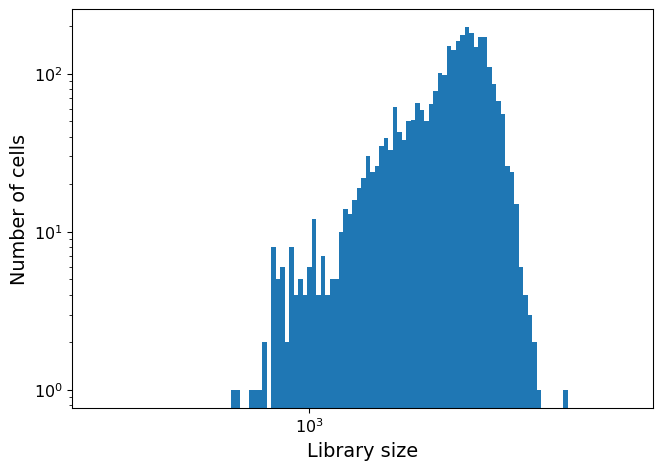

In [5]:
scprep.plot.plot_library_size(hlca_counts)

# 3. Preprocessing: Filtering, Normalizing, and Transforming

## 3.1 Filtering

This data, however, has already had very extensive filtering and QC.
Based on the core model, there are no high mitochondria percentages and
few outliers. So, we will skip the outlier step as this eliminates very
few cells (\< 1%).

In [6]:
hlca_counts = scprep.filter.filter_rare_genes(hlca_counts, min_cells=6)
hlca_counts.shape

(3032, 14395)

## 3.2 Normalization

In [7]:
hlca_counts = scprep.normalize.library_size_normalize(hlca_counts)
hlca_counts.head(2)

2 rows × 14395 columns

## 3.3 Transformation

In [8]:
hlca_counts = scprep.transform.sqrt(hlca_counts)

# 4. PHATE

In [9]:
phate_operator = phate.PHATE(n_jobs=-2, random_state=13)
Y_phate = phate_operator.fit_transform(hlca_counts)

Calculating PHATE...
  Running PHATE on 3032 observations and 14395 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 10.04 seconds.
    Calculating KNN search...
    Calculated KNN search in 1.91 seconds.
    Calculating affinities...
    Calculated affinities in 0.59 seconds.
  Calculated graph and diffusion operator in 12.70 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 0.53 seconds.
    Calculating KMeans...
    Calculated KMeans in 6.70 seconds.
  Calculated landmark operator in 8.90 seconds.
  Calculating optimal t...
    Automatically selected t = 12
  Calculated optimal t in 5.98 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 2.08 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 7.50 seconds.
Calculated PHATE in 37.18 seconds.

/users/jbenjami/.local/lib/python3.9/site-packages/scprep/plot/utils.py:104: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


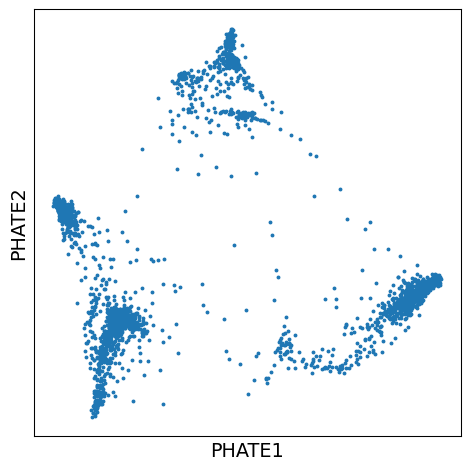

In [10]:
scprep.plot.scatter2d(Y_phate, ticks=None, label_prefix="PHATE", figsize=(5,5),
                      filename="pericyte_phate_clustering.pdf", dpi=300)

# 5. Plotting

## 5.1 Angiotensin II receptor 1 (AGTR1)

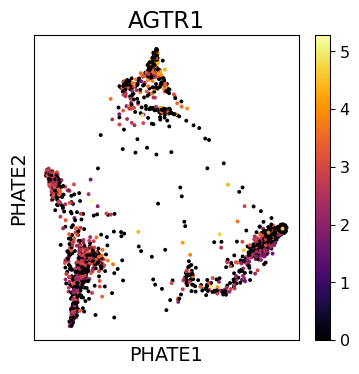

In [11]:
# Plotting mitochondrial expression
fig, ax = plt.subplots(1, figsize=(4,4))
scprep.plot.scatter2d(Y_phate, ax=ax, c=hlca_counts['AGTR1'],
                      title='AGTR1', ticks=False, label_prefix='PHATE',
                      filename="pericyte_phate_clustering.AGTR1.pdf", dpi=300)
fig.tight_layout()

## 5.2 KDE plot of pericytes

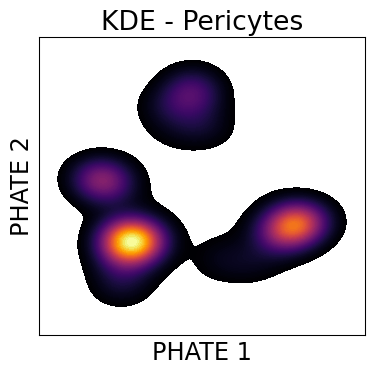

In [12]:
fig, ax = plt.subplots(1, figsize=(4,4))
kde_plot = sns.kdeplot(x=Y_phate[:, 0], y=Y_phate[:, 1], fill=True, ax=ax, zorder=0, 
                       n_levels=100, cmap="inferno")

ax.set_xticks([]); ax.set_yticks([])
ax.set_xlabel('PHATE 1', fontsize=18); ax.set_ylabel('PHATE 2', fontsize=18)
ax.set_title('KDE - Pericytes', fontsize=20)
fig.tight_layout()

fig = kde_plot.get_figure()
fig.savefig("pericyte_phate_kde.pdf") 

## 5.3 Clustering data using PHATE

/users/jbenjami/.local/lib/python3.9/site-packages/phate/cluster.py:57: FutureWarning:

k is deprecated. Please use n_clusters in future.

/users/jbenjami/.local/lib/python3.9/site-packages/scprep/plot/utils.py:104: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


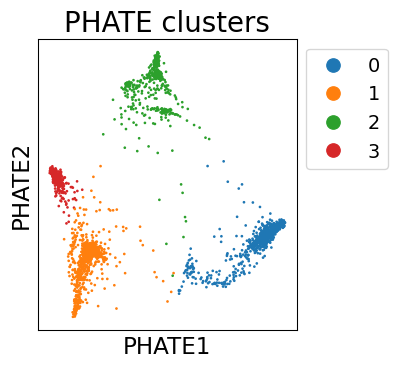

In [13]:
clusters = phate.cluster.kmeans(phate_operator, k=4)

scprep.plot.scatter2d(Y_phate, c=clusters, s=1,figsize=(4.3,4), ticks=None, label_prefix='PHATE',
                      legend_anchor=(1,1), fontsize=12, title='PHATE clusters',
                      filename="pericyte_phate_clustering.kmeans.pdf", dpi=300)

fig.tight_layout()

# 6. Comparison of PHATE clusters and AGTR1 expressoin

## 6.1 Subset data

In [14]:
gene_list = []
for item in hlca_counts.columns:
    gene_list.append(str(item).replace("('", "").replace("',)", ""))

adata = adata[hlca_counts.index, adata.var.feature_name.isin(gene_list)]
adata.obsm["X_phate"] = Y_phate
adata.obs["phate_clusters"] = ["Group_"+str(clu) for clu in clusters]
adata

/tmp/ipykernel_97912/2217928001.py:6: ImplicitModificationWarning:

Setting element `.obsm['X_phate']` of view, initializing view as actual.


AnnData object with n_obs × n_vars = 3032 × 14395
    obs: 'suspension_type', 'donor_id', 'is_primary_data', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'tissue_ontology_term_id', 'organism_ontology_term_id', 'sex_ontology_term_id', 'BMI', 'age_or_mean_of_age_range', 'age_range', 'anatomical_region_ccf_score', 'ann_coarse_for_GWAS_and_modeling', 'ann_finest_level', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'cause_of_death', 'dataset', 'entropy_dataset_leiden_3', 'entropy_original_ann_level_1_leiden_3', 'entropy_original_ann_level_2_clean_leiden_3', 'entropy_original_ann_level_3_clean_leiden_3', 'entropy_subject_ID_leiden_3', 'fresh_or_frozen', 'leiden_1', 'leiden_2', 'leiden_3', 'leiden_4', 'leiden_5', 'log10_total_counts', 'lung_condition', 'mixed_ancestry', 'n_genes_detected', 'original_ann_highest_res', 'original_ann_level_1', 'or

## 6.2 Qualitative review

In [15]:
hlca_counts.loc[:, "PHATE"] = clusters
hlca_counts.loc[:, "patient"] = adata.obs["donor_id"]
df = pl.from_pandas(hlca_counts.loc[:, ["AGTR1", "PHATE", "patient"]])\
       .rename({"('AGTR1',)": "AGTR1", "('PHATE',)": "PHATE", 
                "('patient',)": "patient"})

df.group_by(["PHATE", "patient"]).agg([pl.sum("AGTR1").name.suffix("_sum"), 
                                       pl.mean("AGTR1").name.suffix("_mean"),
                                       pl.count("AGTR1").name.suffix("_count"),
                                       pl.std("AGTR1").name.suffix("_std")])\
  .sort("PHATE")

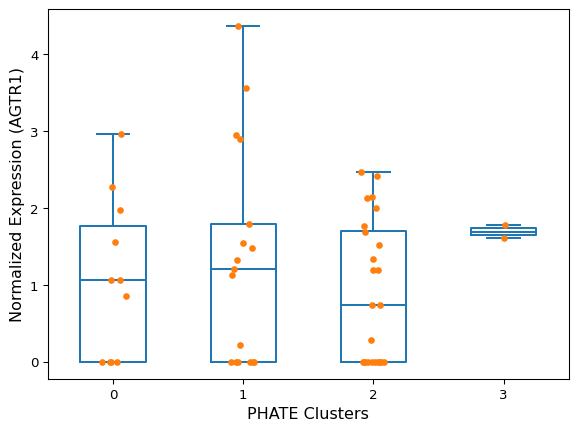

In [16]:
dx = df.group_by(["PHATE", "patient"]).agg(pl.mean("AGTR1"))
ax = sns.boxplot(data=dx, x="PHATE", y="AGTR1", fill=False, width=0.5)
box_plot = sns.stripplot(data=dx, x="PHATE", y="AGTR1", ax=ax)
ax.set_xlabel('PHATE Clusters', fontsize=12); 
ax.set_ylabel('Normalized Expression (AGTR1)', fontsize=12)
fig.tight_layout()

fig = box_plot.get_figure()
fig.savefig("pericyte_phate.boxplot_AGTR1.pdf") 

## 6.3 Statistical comparison

In [17]:
c0 = dx.filter(pl.col("PHATE") == 0).to_pandas().AGTR1.values
c1 = dx.filter(pl.col("PHATE") == 1).to_pandas().AGTR1.values
c2 = dx.filter(pl.col("PHATE") == 2).to_pandas().AGTR1.values
c3 = dx.filter(pl.col("PHATE") == 3).to_pandas().AGTR1.values

f_oneway(c0, c1, c2, c3)

F_onewayResult(statistic=0.6774824662902307, pvalue=0.5699369537140733)

In [18]:
model = MultiComparison(dx.to_pandas().AGTR1, dx.to_pandas().PHATE)
res_mod = model.tukeyhsd()
print(res_mod)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     0      1   0.2537 0.9349  -0.891 1.3985  False
     0      2  -0.1684 0.9756 -1.2455 0.9088  False
     0      3   0.6273 0.8833 -1.6468 2.9014  False
     1      2  -0.4221 0.6321 -1.3599 0.5157  False
     1      3   0.3735 0.9695  -1.838  2.585  False
     2      3   0.7956 0.7664 -1.3817 2.9729  False
---------------------------------------------------

# 7. Trajectory inference

## 7.1 Normalize based counts

In [19]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
adata.raw = adata

normalizing counts per cell
    finished (0:00:00)

In [20]:
adata.var[adata.var.feature_name.isin(["AGTR1"])]

## 7.2 Processing for PAGA

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:16)
drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fr', graph_drawing coordinates (adata.obsm) (0:00:23)
Consider running `set_figure_params(dpi_save=...)`, which will adjust `matplotlib.rcParams['savefig.dpi']`

/users/jbenjami/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


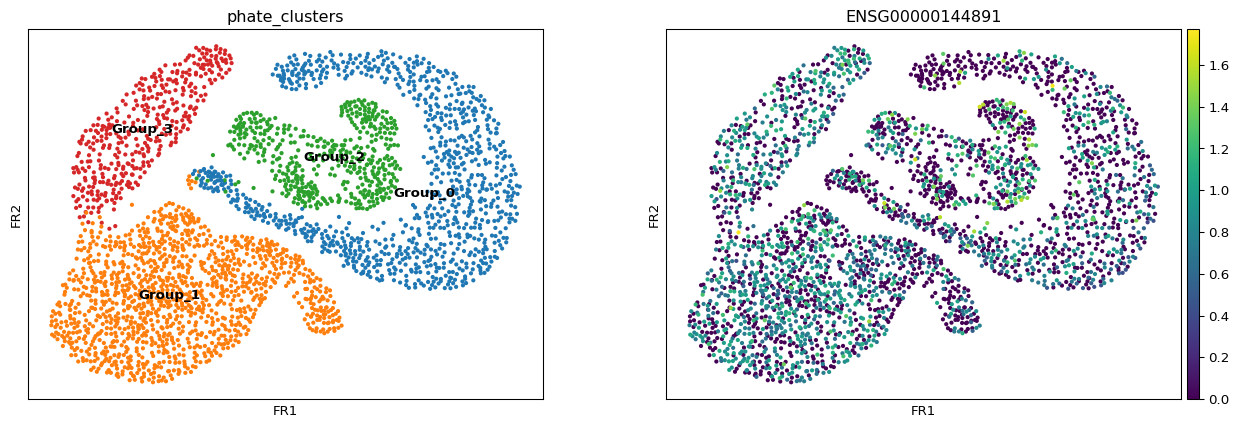

In [21]:
sc.pp.neighbors(adata, n_neighbors=50, use_rep="X_phate", random_state=13)
sc.tl.draw_graph(adata, random_state=13)
sc.pl.draw_graph(adata, color=["phate_clusters", "ENSG00000144891"], 
                 legend_loc="on data", save=".pericyte_phate.pdf")

## 7.3 Clustering and PAGA

running Leiden clustering
    finished: found 12 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])

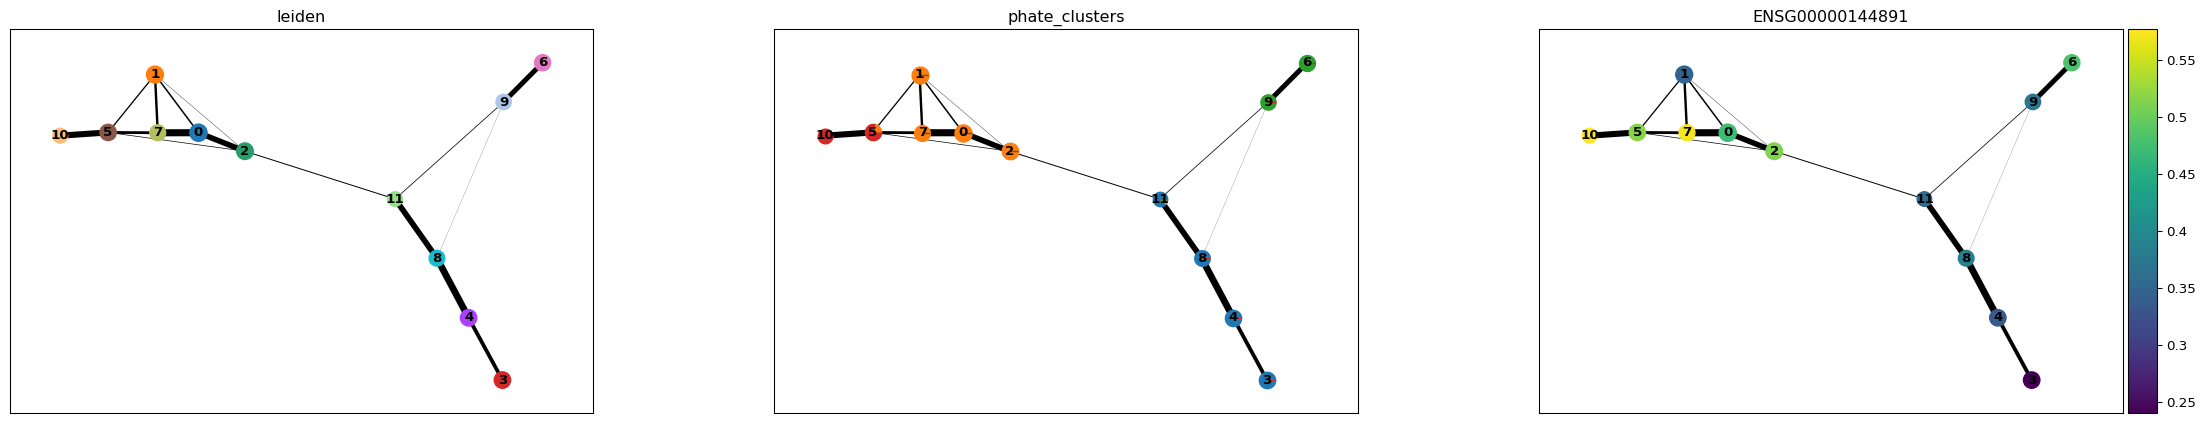

In [22]:
sc.tl.leiden(adata, resolution=0.5, random_state=13)
sc.tl.paga(adata, groups="leiden")
sc.pl.paga(adata, color=["leiden", "phate_clusters", "ENSG00000144891"],
           save=".pericyte_phate.leiden.pdf")

## 7.4 PAGA embedding

drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fr', graph_drawing coordinates (adata.obsm) (0:00:10)

/users/jbenjami/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored

/users/jbenjami/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


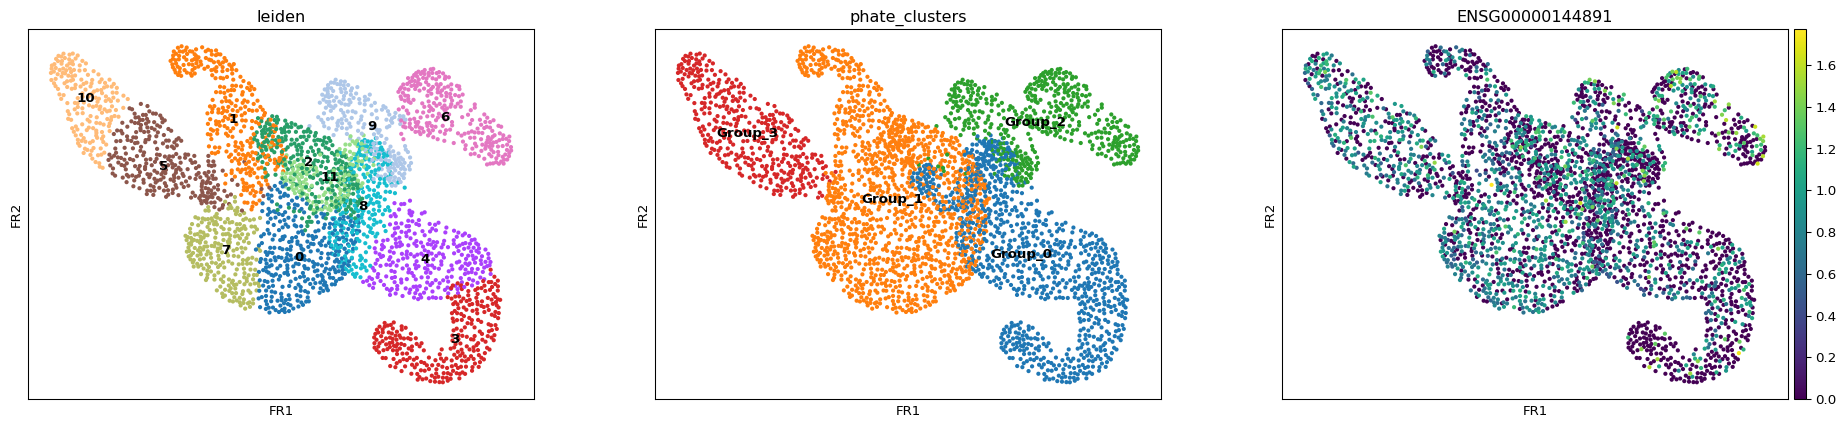

In [23]:
sc.tl.draw_graph(adata, init_pos="paga")
sc.pl.draw_graph(adata, color=["leiden", "phate_clusters", "ENSG00000144891"], 
                 legend_loc="on data", save=".pericyte_phate.paga_embedding.pdf")

# 8. Pseudotime visualization

## 8.1 Choose a root cell for diffusion pseudotime

In [24]:
adata.uns["iroot"] = np.flatnonzero(adata.obs["leiden"] == '11')[0]

## 8.2 Compute diffusion pseudotime

computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.99956065 0.99860865 0.9981825  0.9964726  0.99345714
     0.99140364 0.9888171  0.9869463  0.9852987  0.98470664 0.98118716
     0.9786843  0.97644734 0.9713054 ]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)
computing Diffusion Pseudotime using n_dcs=10
    finished: added
    'dpt_pseudotime', the pseudotime (adata.obs) (0:00:00)

/users/jbenjami/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


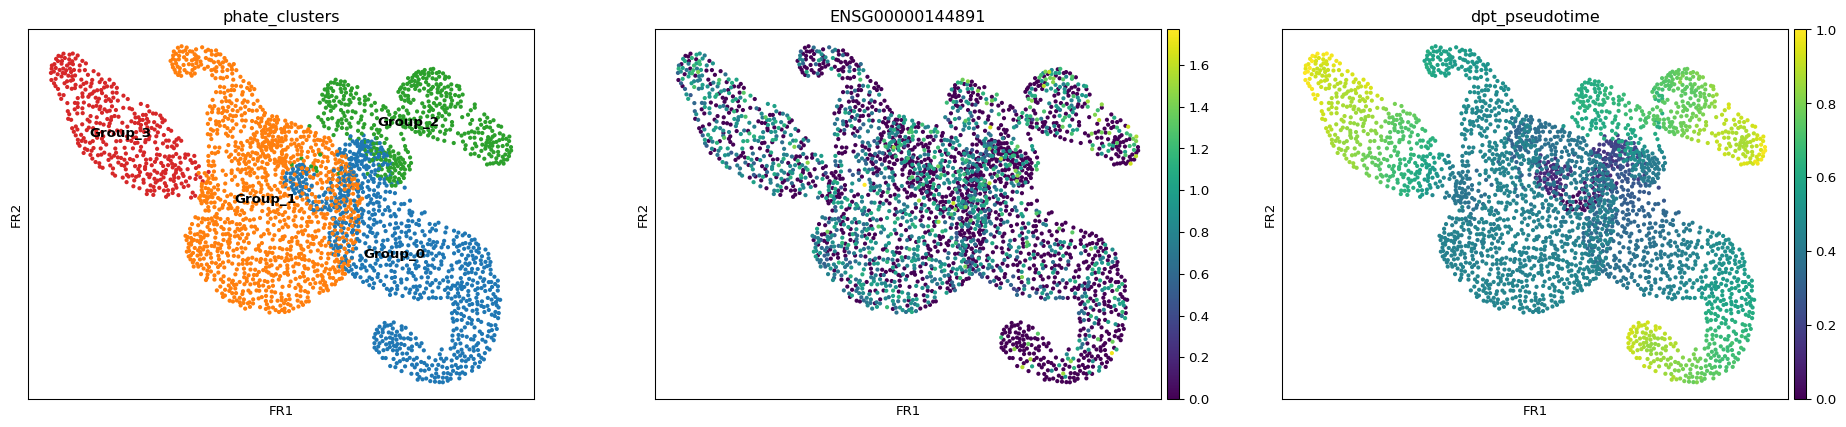

In [25]:
sc.tl.dpt(adata)
sc.pl.draw_graph(adata, color=["phate_clusters", "ENSG00000144891", "dpt_pseudotime"], 
                 legend_loc="on data", save=".pericytes_phate.diff_pseudotime.pdf")

# 9. Session information

In [26]:
session_info.show()

Click to view session information 
 
-----
anndata 0.10.5.post1
matplotlib 3.7.1
numpy 1.24.4
pandas 2.0.3
phate 1.0.11
polars 0.19.12
scanpy 1.9.8
scipy 1.8.1
scprep 1.2.3
seaborn 0.13.2
session_info 1.0.0
statsmodels 0.14.0
-----
 
 
 Click to view modules imported as dependencies 
 
PIL 8.2.0
anyio NA
argcomplete NA
arrow 1.2.3
asttokens NA
attr 23.2.0
attrs 23.2.0
babel 2.10.3
backcall 0.2.0
beta_ufunc NA
binom_ufunc NA
cairo 1.20.1
certifi 2024.02.02
cffi 1.14.5
chardet 4.0.0
charset_normalizer 3.3.2
cloudpickle 2.1.0
comm 0.2.2
contourpy 1.1.0
cycler 0.10.0
cython_runtime NA
dask 2022.8.1
dateutil 2.8.2
debugpy 1.6.3
decorator 5.1.1
deprecated 1.2.13
exceptiongroup 1.0.0rc8
executing 0.10.0
fastjsonschema NA
fontTools 4.33.3
fqdn NA
fsspec 2022.7.1
future 0.18.2
gi 3.40.1
gio NA
glib NA
gobject NA
graphtools 1.5.3
gtk NA
h5py 3.7.0
hypergeom_ufunc NA
idna 2.10
igraph 0.10.4
importlib_metadata NA
importlib_resources NA
ipykernel 6.15.1
ipywidgets 8.1.2
isoduration NA
jedi 0.18.1
jinja2 3.1.1
joblib 1.2.0
json5 NA
jsonpointer 2.3
jsonschema 4.21.1
jsonschema_specifications NA
jupyter_events 0.10.0
jupyter_server 2.13.0
jupyterlab_server 2.25.4
kaleido 0.2.1
kiwisolver 1.4.3
leidenalg 0.9.1
llvmlite 0.42.0
louvain 0.8.1
lxml 4.9.1
markupsafe 2.1.1
matplotlib_inline 0.1.6
mpl_toolkits NA
natsort 8.2.0
nbformat 5.4.0
nbinom_ufunc NA
netifaces 0.10.6
networkx 2.8.8
numba 0.59.0
opt_einsum v3.3.0
overrides NA
packaging 21.3
parso 0.8.3
patsy 0.5.2
pexpect 4.8.0
pickleshare 0.7.5
pkg_resources NA
platformdirs 3.8.0
plotly 5.9.0
ply 3.11
prometheus_client NA
prompt_toolkit 3.0.30
psutil 5.9.1
ptyprocess 0.7.0
pure_eval 0.2.2
pyarrow 15.0.0
pycparser 2.20
pydev_ipython NA
pydevconsole NA
pydevd 2.8.0
pydevd_file_utils NA
pydevd_plugins NA
pydevd_tracing NA
pygments 2.13.0
pygsp 0.5.1
pynndescent 0.5.8
pyparsing 3.0.9
pythonjsonlogger NA
pytz 2022.1
referencing NA
requests 2.31.0
rfc3339_validator 0.1.4
rfc3986_validator 0.1.1
rpds NA
s_gd2 1.8.1
send2trash NA
six 1.16.0
sklearn 1.4.1.post1
sniffio 1.2.0
socks 1.7.1
stack_data 0.4.0
swig_runtime_data4 NA
tasklogger 1.2.0
tenacity NA
texttable 1.6.7
threadpoolctl 3.1.0
tlz 0.12.0
toolz 0.12.0
torch 1.13.1+cu117
tornado 6.2
tqdm 4.64.0
traitlets 5.9.0
typing_extensions NA
umap 0.5.5
uri_template NA
urllib3 1.26.5
wcwidth 0.2.5
webcolors 1.11.1
websocket 1.4.0
wrapt 1.16.0
yaml 6.0
zipp NA
zmq 25.0.0
zoneinfo NA
zstandard 0.18.0
 
 <!-- seems like this ends pre, so might as well be explicit -->
 
-----
IPython 8.4.0
jupyter_client 8.0.2
jupyter_core 5.2.0
jupyterlab 4.1.5
notebook 7.1.2
-----
Python 3.9.16 (main, Dec 8 2022, 00:00:00) [GCC 11.3.1 20221121 (Red Hat 11.3.1-4)]
Linux-5.14.0-284.11.1.el9_2.x86_64-x86_64-with-glibc2.34
-----
Session information updated at 2024-03-30 16:23